# visualzing output of WDM on zf

## imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scanpy -q

In [3]:
!pip install -U plotly -q   # for making Sankey diagram

In [4]:
!pip install -U kaleido -q   # for saving Sankey diagram

In [5]:
import pandas as pd
import scanpy as sc
import numpy as np
import torch
import sys
from scipy.spatial.distance import cdist
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import sys
import importlib

import matplotlib.pyplot as plt

In [6]:
filehandle_wdm = 'drive/Othercomputers/numac/GitHub/WDM/'
filehandle_load_output = 'drive/Othercomputers/numac/GitHub/celltypediscovery/_wdm_save/'
filehandle_zf = 'drive/MyDrive/DX/_data/zebrafish/cleaned_common_pca/'
filehandle_ctd = 'drive/Othercomputers/numac/GitHub/celltypediscovery/'


sys.path.insert(0, filehandle_wdm)
sys.path.insert(0, filehandle_load_output)
sys.path.insert(0, filehandle_zf)
sys.path.insert(0, filehandle_ctd)

import clustering
import util_LR
import util_zf
import FRLC_LRDist

## reload

In [56]:
importlib.reload(clustering)
importlib.reload(util_LR)
importlib.reload(util_zf)
importlib.reload(FRLC_LRDist)

<module 'FRLC_LRDist' from '/content/drive/Othercomputers/numac/GitHub/WDM/FRLC_LRDist.py'>

## device

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'On device: {device}')
dtype = torch.float64

On device: cuda


## load zf: spatial, annotation hard clusterings as $Q$'s

In [29]:
# daniocell_dir = '/scratch/gpfs/ph3641/zebrafish/daniocell.h5ad'
# adata_daniocell = sc.read_h5ad(daniocell_dir)
# stages = np.unique(adata_daniocell.obs['hpf'].values)

zf_list = ['zf3', 'zf5', 'zf10', 'zf12', 'zf18', 'zf24']
zf_names = zf_list
filehandles_zf = [filehandle_zf + 'pair' + str(k) + '/' for k in range(len(zf_list))]
N = len(filehandles_zf)

spatial_list = []
exclude_rows = [None, None, None, None, None, None] # [1099, None, None, 325, None, None]

for i in range(len(zf_list)):
    file_spatial = filehandles_zf[i] + zf_names[i] +'_spatial.npy'
    if i == len(zf_list) - 1:
        file_spatial = filehandles_zf[i-1] + zf_names[i] +'_spatial.npy'
    spatial = np.load(file_spatial)
    nidx = exclude_rows[i]
    if nidx is not None:
        spatial = np.concatenate((spatial[:nidx,:], spatial[nidx+1:,:]))
    spatial_list.append(spatial)

In [30]:
N = len(filehandles_zf)
Qs = [None]*(N-1)
Rs = [None]*(N-1)

key = 'bin_annotation'

labels = []

for i in range(N-2, -1, -1):

    s1_name = zf_names[i]
    s2_name = zf_names[i+1]

    print(f'Slice pair {i}, aligning {s1_name} to {s2_name}')

    adata_pair = sc.read_h5ad(filehandle_zf + f'pair{i}/' + s1_name + '_' + s2_name + '.h5ad')

    adata1 = adata_pair[adata_pair.obs['timepoint'] == 1]
    # sc.pp.normalize_total(adata1)
    # sc.pp.log1p(adata1)

    adata2 = adata_pair[adata_pair.obs['timepoint'] == 2]
    # sc.pp.normalize_total(adata2)
    # sc.pp.log1p(adata2)

    encoder1 = OneHotEncoder(sparse_output=False)
    ys_onehot1 = encoder1.fit_transform(adata1.obs[key].values.reshape(-1, 1))
    _Q = ys_onehot1 / np.sum(ys_onehot1)

    encoder2 = OneHotEncoder(sparse_output=False)
    ys_onehot2 = encoder2.fit_transform(adata2.obs[key].values.reshape(-1, 1))
    _R = ys_onehot2 / np.sum(ys_onehot2)

    labels.append(list(encoder2.categories_[0]))

    if i == 0:
        labels.append(list(encoder1.categories_[0]))

    _Q, _R = torch.from_numpy(_Q).to(device).float(), torch.from_numpy(_R).to(device).float()

    # Filter rows
    nidx_1, nidx_2 = exclude_rows[i], exclude_rows[i+1]
    if nidx_1 is not None:
        _Q = torch.cat((_Q[:nidx_1,:], _Q[nidx_1+1:,:]))
    if nidx_2 is not None:
        _R = torch.cat((_R[:nidx_2,:], _R[nidx_2+1:,:]))

    Qs[i], Rs[i] = _Q, _R

Slice pair 4, aligning zf18 to zf24
Slice pair 3, aligning zf12 to zf18
Slice pair 2, aligning zf10 to zf12
Slice pair 1, aligning zf5 to zf10
Slice pair 0, aligning zf3 to zf5


## set ranks, set `i` = first timepoint of three: `i`, `i+1`, `i+2`

In [31]:
ranks = [(3,7),(7,7),(7,11),(11,14),(14,19)]

i=2

r1, r2 = ranks[i]
r2, r3 = ranks[i+1]

## load features and spatial coords specific to the triple

In [32]:
s0_name = zf_names[i]
s1_name = zf_names[i+1]
s2_name = zf_names[i+2]

filehandle_pair1 = filehandle_zf + 'pair' + str(i) + '/'
filehandle_pair2 = filehandle_zf + 'pair' + str(i+1) + '/'

X0 = np.load(filehandle_pair1 + s0_name + '_feature.npy')
X1 = np.load(filehandle_pair1 + s1_name + '_feature.npy')
X2 = np.load(filehandle_pair2 + s2_name + '_feature.npy')

S0 = spatial_list[i]
S1 = spatial_list[i+1]
S2 = spatial_list[i+2]

## load `WDM` output

In [33]:
wdm_Q0 = np.load(filehandle_load_output + 'wdm_Q0.npy')
wdm_Q1 = np.load(filehandle_load_output + 'wdm_Q1.npy')
wdm_Q2 = np.load(filehandle_load_output + 'wdm_Q2.npy')

wdm_T0 = np.load(filehandle_load_output + 'wdm_T0.npy')
wdm_T1 = np.load(filehandle_load_output + 'wdm_T1.npy')

ann_Q0 = np.load(filehandle_load_output + 'ann_Q0.npy')

ann_Q1 = np.load(filehandle_load_output + 'ann_Q1.npy')
ann_Q1_imp = np.load(filehandle_load_output + 'ann_Q1_imp.npy')

ann_Q2 = np.load(filehandle_load_output + 'ann_Q2.npy')

ann_T0_imp = np.load(filehandle_load_output + 'ann_T0_imp.npy')
ann_T1_imp = np.load(filehandle_load_output + 'ann_T1_imp.npy')

ann_T0 = np.load(filehandle_load_output + 'ann_T0.npy')
ann_T1 = np.load(filehandle_load_output + 'ann_T0.npy')

## load labels

In [34]:
slice0_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice0_types.npy'))
slice1_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice1_types.npy'))
slice2_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice2_types.npy'))
slice3_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice3_types.npy'))
slice4_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice4_types.npy'))
slice5_types = list(np.load(filehandle_ctd + 'a_gt_types/' + 'slice5_types.npy'))

In [35]:
ct_labels = [ list(set(slice0_types)),
               list(set(slice1_types)),
                list(set(slice2_types)),
                list(set(slice3_types)),
                list(set(slice4_types)),
                list(set(slice5_types))]

ct_ann_0 = ct_labels[i]
ct_ann_1 = ct_labels[i+1]
ct_ann_2 = ct_labels[i+2]

node_labels = [ct_ann_0, ct_ann_1, ct_ann_2]

# 1 . transitions between three annotated slices

## plot diffmap

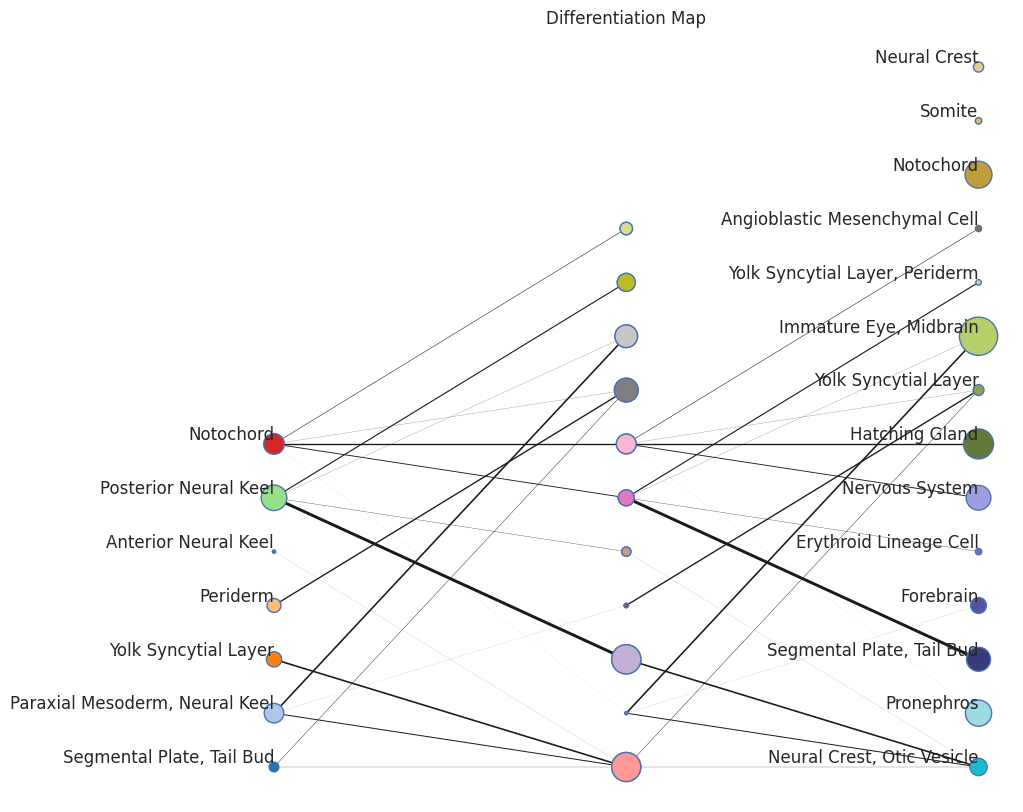

In [54]:
Qs_ann = [ann_Q0, ann_Q1, ann_Q2]
Ts_ann = [ann_T0, ann_T1]
node_labels1 = [ct_ann_0, None, ct_ann_2]

clustering.diffmap_from_QT(Qs_ann, Ts_ann, node_labels=node_labels1)

## clustering

In [57]:
Ss = [S0, S1, S2]

clustering.plot_clusters_from_QT(Ss, Qs_ann, Ts_ann, node_labels)


Output hidden; open in https://colab.research.google.com to view.

# 2. imputing middle slice from annotations on either side

## plot diffmap

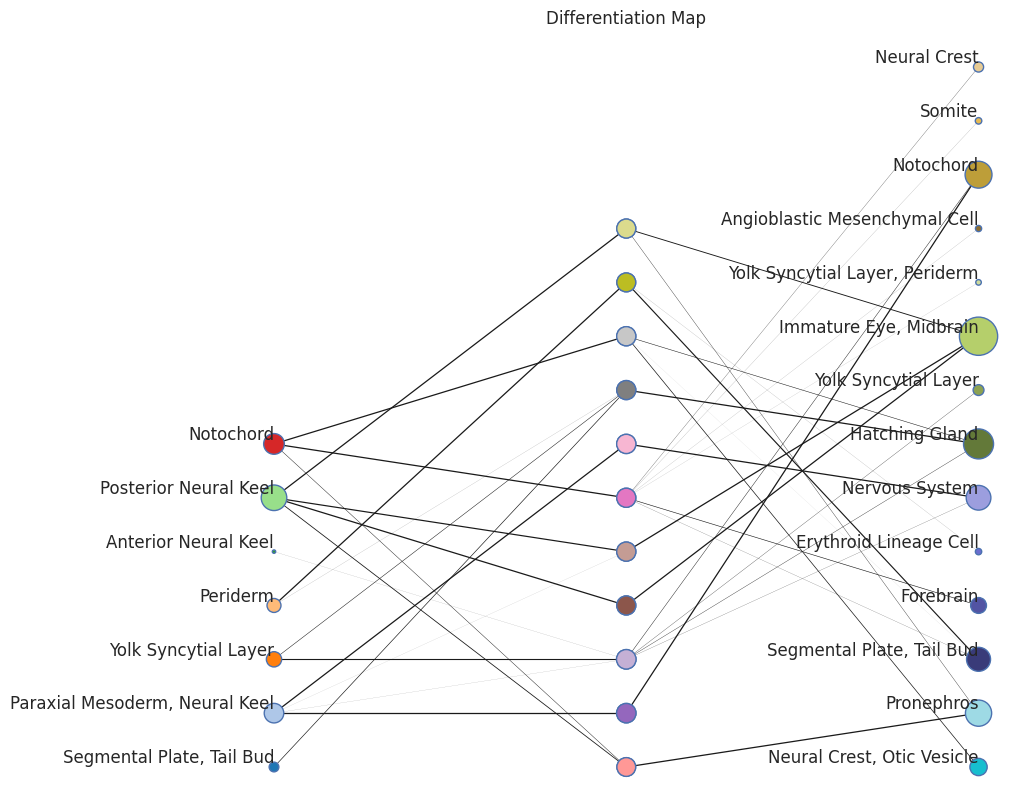

In [24]:
Qs_ann_imp = [ann_Q0, ann_Q1_imp, ann_Q2]
Ts_ann_imp = [ann_T0_imp, ann_T1_imp]

node_labels2 = [ct_ann_0, None, ct_ann_2]

clustering.diffmap_from_QT(Qs_ann_imp, Ts_ann_imp, node_labels=node_labels2)

## clustering

In [26]:
clustering.plot_clusters_from_QT(Ss, Qs_ann_imp, Ts_ann_imp, node_labels2)

Output hidden; open in https://colab.research.google.com to view.

## sankey between annotations and our middle time point

In [27]:
import plotly.graph_objects as go

In [28]:
df1 = pd.DataFrame({'GT clusters': ann_labels_1, 'Predicted clusters': ml_labels_Q1})
transition_matrix = pd.crosstab(df1['GT clusters'], df1['Predicted clusters'])

# print("Transition Matrix:")
# print(transition_matrix)

# Get unique cluster labels
gt_clusters = sorted(df1['GT clusters'].unique())
pred_clusters = sorted(df1['Predicted clusters'].unique())

# Define node labels
labels = ct_ann_1 + [f'Predicted Cluster {i}' for i in pred_clusters]


# Number of clusters
num_gt_clusters = len(gt_clusters)
num_pred_clusters = len(pred_clusters)

# Function to generate colors
def generate_colors(num_colors, colormap_name):
    cmap = plt.get_cmap(colormap_name)
    colors = cmap(np.linspace(0, 1, num_colors))
    return ['#{:02x}{:02x}{:02x}'.format(int(r*255), int(g*255), int(b*255)) for r, g, b, _ in colors]

# Generate colors for clusters
gt_colors = generate_colors(num_gt_clusters, 'Blues')       # Colormap for GT clusters
pred_colors = generate_colors(num_pred_clusters, 'Oranges') # Colormap for Predicted clusters

# Combine colors
node_colors = gt_colors + pred_colors

# Initialize lists for sources, targets, and values
threshold = 0   # NOTE: changing threshold will disappear small pop cell types in GT
source_indices = []
target_indices = []
values = []

for gt_idx, gt_cluster in enumerate(gt_clusters):
    for pred_idx, pred_cluster in enumerate(pred_clusters):
        if gt_cluster in transition_matrix.index and pred_cluster in transition_matrix.columns:
            count = transition_matrix.at[gt_cluster, pred_cluster]
            if count > threshold:
                source_indices.append(gt_idx)
                target_indices.append(pred_idx + num_gt_clusters)
                values.append(count)


# Create the Sankey diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        label=labels,
        color=node_colors
    ),
    link=dict(
        source=source_indices,
        target=target_indices,
        value=values
    )
)])

# Update layout
fig.update_layout(
    title_text="Cluster Transition Sankey Diagram",
    font_size=10,
    width=1000,    # Adjust width as needed
    height=800     # Adjust height as needed
)

# Display the diagram
fig.show()

# Export as JPEG
fig.write_image("sankey_diagram_1.jpg")

# Export as PDF
# fig.write_image("sankey_diagram_1.pdf")

# Export as SVG
# fig.write_image("sankey_diagram_1.svg")

# Export as PNG (default if no extension is specified)
# fig.write_image("sankey_diagram_1.png")

## can we register middle timepoint clusters?

## 2.5. ... let me see if I have acces to zf colors used by zesta

In [ ]:
import json

color_list = []

# Open the JSON file

for i in zf_names:
    with open(filehandle_zf + 'colors/' + 'zf3_colors.json', 'r') as file:
        data = json.load(file)

# 3. unsupervised `WDM`